# Standard imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpTrainingFrame

In [2]:
df_mc=pd.read_hdf('pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')

# Prepare classifier and training frame

split into test and training data

In [3]:
clf=HpAlgorithms.getGradientBDTClassifier()#options={"n_estimators":10})

In [4]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

# Calibrate ROC AUC to Cross section

Fit results: [ 5.84983620e-03 -4.16702246e-03  1.22938606e-03 -1.36789294e-05]


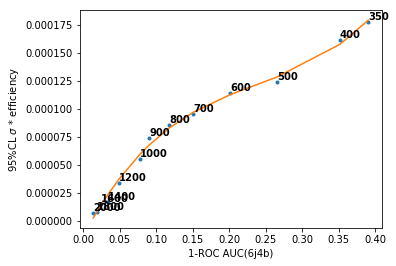

In [5]:
data = pd.read_csv('aucvsxslimit.txt', sep="\t", header=None)
data.columns=['mass','xslimit','oneminusauc']
z = np.polyfit(data.oneminusauc[5:], data.xslimit[5:], 3)
p = np.poly1d(z)

p1 = plt.plot(data.oneminusauc[5:], data.xslimit[5:], '.', data.oneminusauc[5:], p(data.oneminusauc[5:]), '-')
for line in range(5,data.shape[0]):
    plt.text(data.oneminusauc[line], data.xslimit[line]+0.000002, data.mass[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.gcf().subplots_adjust(left=0.2)
plt.xlabel("1-ROC AUC(6j4b)")
plt.ylabel("95%CL $\sigma$ * efficiency")
print("Fit results:", z)

# Calculate the cross mass score

In [6]:
from sklearn.metrics import roc_auc_score
from HpMLFeatureNormalisation import WeightedStandardScaler

hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

def calculateCrossMassScore(clf, htf,hpmasses, normalizeInputs=False):
    """ calculate result of training for one mass point and evaluation on other mass point
        clf: classifier
        htf: HpTrainingFrame
        hpmasses, list of H+ masses
        normalizeInputs: if true the features are normalised to average 0 and variance 1 before fitting
    """

    X_train={}
    X_test={}
    X_eval={}
    y_train={}
    y_test={}
    y_eval={}
    w_train={}
    w_test={}
    w_eval={}
    
    if normalizeInputs:
        wss=WeightedStandardScaler()
    
    for hpmass in hpmasses:
        X_train[hpmass], X_test[hpmass], X_eval[hpmass], y_train[hpmass], y_test[hpmass],y_eval[hpmass], w_train[hpmass], w_test[hpmass], w_eval[hpmass]=htf.prepare(hpmass=hpmass)
        if normalizeInputs:
            wss.fit(X_train[hpmass],y_train[hpmass],sample_weight=w_train[hpmass])
            X_train[hpmass],y_train[hpmass],w_train[hpmass]=wss.transform(X_train[hpmass], y_train[hpmass], sample_weight=w_train[hpmass])
            X_test[hpmass],y_test[hpmass],w_test[hpmass]=wss.transform(X_test[hpmass], y_test[hpmass], sample_weight=w_test[hpmass])
    
    scorematrix=np.zeros((len(hpmasses),len(hpmasses)))
    
    for i,hpmass in enumerate(hpmasses):
        print("Training for m(H+)=", hpmass)
 
        clf.fit(X_train[hpmass], y_train[hpmass], sample_weight=w_train[hpmass])
    
        for j,hpmass2 in enumerate(hpmasses):
            print("Evaluating for m(H+)=", hpmass2," -> ",)
            score=1.-roc_auc_score(y_test[hpmass2], clf.decision_function(X_test[hpmass2]), sample_weight=w_test[hpmass2])
            scorematrix[i,j]=score
            print(score)
    return scorematrix

scorematrix=calculateCrossMassScore(clf,htf,hpmasses)

Training for m(H+)= 200
Evaluating for m(H+)= 200  -> 
0.3290842221951199
Evaluating for m(H+)= 225  -> 
0.38970910458349584
Evaluating for m(H+)= 250  -> 
0.4342449953841332
Evaluating for m(H+)= 275  -> 
0.46823750190866376
Evaluating for m(H+)= 300  -> 
0.5009620932005938
Evaluating for m(H+)= 350  -> 
0.5356868733266185
Evaluating for m(H+)= 400  -> 
0.5621111106750134
Evaluating for m(H+)= 500  -> 
0.6166155873641093
Evaluating for m(H+)= 600  -> 
0.6391848673496152
Evaluating for m(H+)= 700  -> 
0.6630104167789981
Evaluating for m(H+)= 800  -> 
0.6824311491012424
Evaluating for m(H+)= 900  -> 
0.6989353221030665
Evaluating for m(H+)= 1000  -> 
0.7118118019554751
Evaluating for m(H+)= 1200  -> 
0.7347692544423503
Evaluating for m(H+)= 1400  -> 
0.7671200848885105
Evaluating for m(H+)= 1600  -> 
0.7782698995521959
Evaluating for m(H+)= 1800  -> 
0.7982984474305924
Evaluating for m(H+)= 2000  -> 
0.8191778259816693
Training for m(H+)= 225
Evaluating for m(H+)= 200  -> 
0.36215106725

In [7]:
from array import array

def plotCrossMassScore(scorematrix1, scorematrix2=None, convertToXSec=False):
    # score matrices can be read from txt file
    # scorematrix1_orig=np.loadtxt("scorematrixnew_normal.txt")
    # scorematrix2_orig=np.loadtxt("scorematrixnew.txt")

    if convertToXSec:
        #z=array("f",[ 5.84983620e-03, -4.16702246e-03,  1.22938606e-03, -1.36789294e-05])
        f=np.poly1d(z)
        this_scorematrix1=f(scorematrix1[5:,5:].copy()) #do not take first 5 values as conversion to xsec is not reliable there
        if not scorematrix2 is None:
            this_scorematrix2=f(scorematrix2[5:,5:].copy())
    else:
        this_scorematrix1=scorematrix1.copy()
        if not scorematrix2 is None:
            this_scorematrix2=scorematrix2.copy()

    title="Normalized input variables"

    hpmassesorig=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
    if convertToXSec:
        hpmasses=hpmassesorig[5:]
    else:
        hpmasses=hpmassesorig
        
    #first plot: compare the results for both methods if evaluated and trained at same mass point (expect same result)
    if not scorematrix2 is None:
        diag1=[scorematrix1[j,j] for j in range(0,scorematrix1.shape[0])]
        diag2=[scorematrix2[j,j] for j in range(0,scorematrix2.shape[0])]

        fig, ax = plt.subplots()
        plt.plot(hpmassesorig, diag1,"-", label="normalised")
        plt.plot(hpmassesorig, diag2,"--", label="default")
        plt.legend(loc="upper right")
        plt.xlabel("H+ mass for evaluation")
        plt.ylabel("ROC AUC")
        plt.show()

    #second plot: one line per training and evaluating it for multiple mass points
    for j in range(this_scorematrix1.shape[1]): #j=index for evaluation
        diag1=this_scorematrix1[j,j]
        #print "Diag:", j, diag1,
        if not scorematrix2 is None: 
            diag2=this_scorematrix2[j,j]
            #print diag2
        #else:
            #print
        for i in range(this_scorematrix1.shape[0]): #i=index for training
            before=this_scorematrix1[i,j]
            this_scorematrix1[i,j]=(this_scorematrix1[i,j]/diag1-1.)*100 #take difference in % to diagonal value, i.e. trained and evaluated at same mass point (=ideal case)
            if not scorematrix2 is None:
                this_scorematrix2[i,j]=(this_scorematrix2[i,j]/diag2-1.)*100
            #print i,j, before, this_scorematrix1[i,j], diag1

    fig, ax = plt.subplots()

    ax.set_ylim(0, 25)
    color=iter(plt.cm.rainbow(np.linspace(0,1,this_scorematrix1.shape[1])))
    for j in range(this_scorematrix1.shape[1]):
        if j %2==0:
            c=next(color)
            plt.plot(hpmasses[max(0,j-4):j+4], this_scorematrix1[max(0,j-4):j+4,j],"-",c=c, label="m(H+)="+str(hpmasses[j])+" GeV") #take only +/-4 mass points for curve to unclutter plot
            plt.plot(hpmasses[max(0,j-4):j+4], this_scorematrix1[max(0,j-4):j+4,j],"*",c=c)
            if not scorematrix2 is None:
                plt.plot(hpmasses[max(0,j-4):j+4], this_scorematrix2[max(0,j-4):j+4,j],"--",c=c)#, label="m(H+)="+str(hpmasses[j])+" GeV")
                #plt.plot(hpmasses[max(0,j-4):j+4], this_scorematrix2[max(0,j-4):j+4,j],"-",c=c, label="m(H+)="+str(hpmasses[j])+" GeV")
                plt.plot(hpmasses[max(0,j-4):j+4], this_scorematrix2[max(0,j-4):j+4,j],"*",c=c)

    plt.xlabel("H+ mass for evaluation")
    if convertToXSec:
        plt.ylabel("% difference to 95% excluded XS at ideal mass for training")
    else:
        plt.ylabel("% difference to ROC at ideal mass for training")

    plt.legend(loc="upper right",title="Training mass")


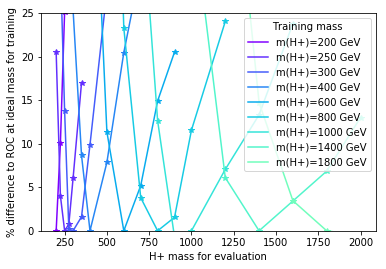

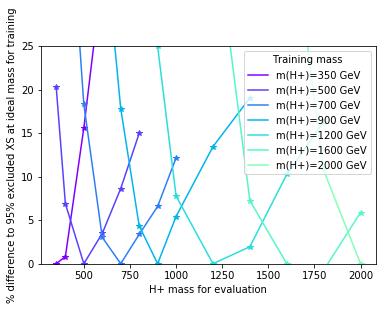

In [8]:
plotCrossMassScore(scorematrix)
plotCrossMassScore(scorematrix,convertToXSec=True)


# Trying with normalised inputs

In [9]:
scorematrix_normalised=calculateCrossMassScore(clf,htf,hpmasses,normalizeInputs=True)

Training for m(H+)= 200
Evaluating for m(H+)= 200  -> 
0.3290842221951199
Evaluating for m(H+)= 225  -> 
0.38981672066447337
Evaluating for m(H+)= 250  -> 
0.4330149041628829
Evaluating for m(H+)= 275  -> 
0.46486134066863727
Evaluating for m(H+)= 300  -> 
0.4986305183634423
Evaluating for m(H+)= 350  -> 
0.5342750886254801
Evaluating for m(H+)= 400  -> 
0.561226919499586
Evaluating for m(H+)= 500  -> 
0.6140041457365288
Evaluating for m(H+)= 600  -> 
0.6388744491318433
Evaluating for m(H+)= 700  -> 
0.6633068066545451
Evaluating for m(H+)= 800  -> 
0.6830354936417173
Evaluating for m(H+)= 900  -> 
0.6990485457989426
Evaluating for m(H+)= 1000  -> 
0.7119362136098871
Evaluating for m(H+)= 1200  -> 
0.7337375792855487
Evaluating for m(H+)= 1400  -> 
0.7663862429635993
Evaluating for m(H+)= 1600  -> 
0.777563212640396
Evaluating for m(H+)= 1800  -> 
0.7971616859518542
Evaluating for m(H+)= 2000  -> 
0.8187483518006801
Training for m(H+)= 225
Evaluating for m(H+)= 200  -> 
0.3621423126775

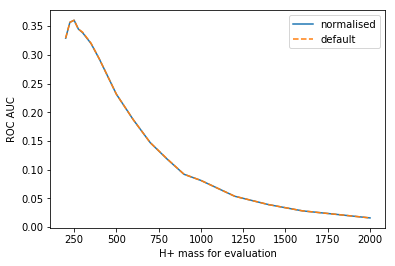

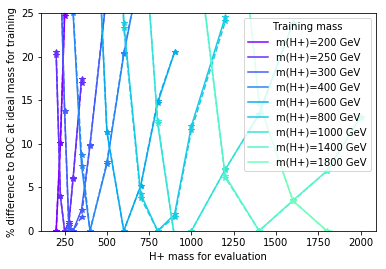

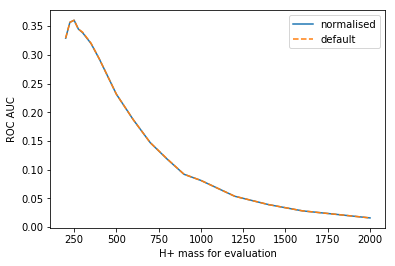

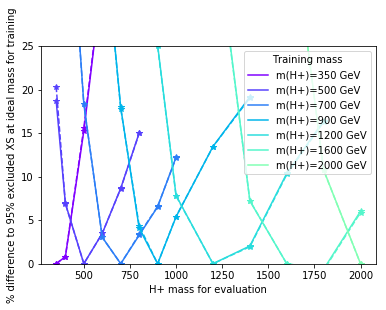

In [10]:
plotCrossMassScore(scorematrix_normalised, scorematrix)
plotCrossMassScore(scorematrix_normalised, scorematrix, convertToXSec=True)